In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [10]:
# read images
# image_names = glob("../../data/split_162930/*.jpg")
image_names = glob("../../data/split_fine/*.jpg")
# image_names = glob("../data/stitching/boat*.jpg")
# image_names = glob("../data/test1/DSC_*.jpg")
imgs = []
for i in image_names:
    _i = cv2.imread(i)
    # _i = cv2.rotate(_i, cv2.ROTATE_90_CLOCKWISE )
    # _i = cv.resize(_i, (0,0), fx=0.25, fy=0.25)
    imgs.append(_i)
# return imgs, image_names

In [11]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 22,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [12]:
def sift_descriptor(good1, good2, img1, img2):
    # sift
    sift = cv2.SIFT_create()
    kp1 = [cv2.KeyPoint(x=f[0], y=f[1], _size=40) for f in good1]
    kp2 = [cv2.KeyPoint(x=f[0], y=f[1], _size=40) for f in good2]
    kp1, des1 = sift.compute(img1, kp1)
    kp2, des2 = sift.compute(img2, kp2)
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    return (kp1, des1, kp2, des2)

In [13]:
def match_descriptor(kp1, des1, kp2, des2):
    # flann matcher
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)  # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1.astype(np.float32),des2.astype(np.float32),k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
    return matches, matchesMask

In [14]:
def draw_matches(img1, img2, kp1, kp2, matchesMask):
    draw_params = dict(matchColor = (0,255,0), singlePointColor = (255,0,0), matchesMask = matchesMask, flags = 0)

    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

    plt.imshow(img3)
    plt.show()

In [15]:
def match_ratio(matches, img1, img2, kp1, kp2, isdraw=False):
    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    if(isdraw):
        img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

        plt.imshow(img3)
        plt.show()
    return good


In [16]:
# warp img0/mosaic instead of img1
mosaic = None
rect=[0,0,0,0]

img0 = cv2.cvtColor(imgs[0],cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(img0, mask = None, **feature_params)

keyframes = [img0]
keypoints = []
keyframe_indices = [0]

6 not enough good matching points, reset img0


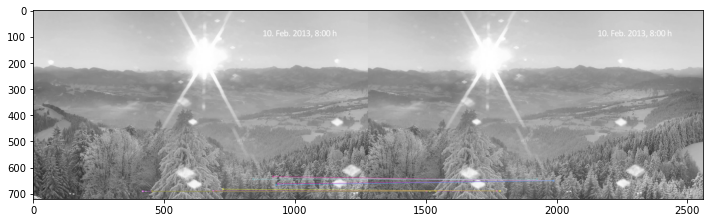

15 not enough good matching points, reset img0


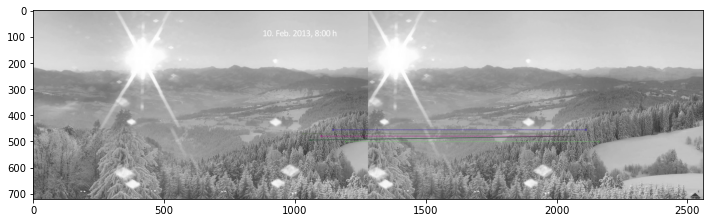

27 not enough good matching points, reset img0


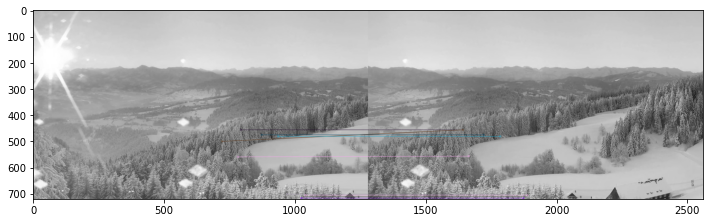

37 not enough good matching points, reset img0


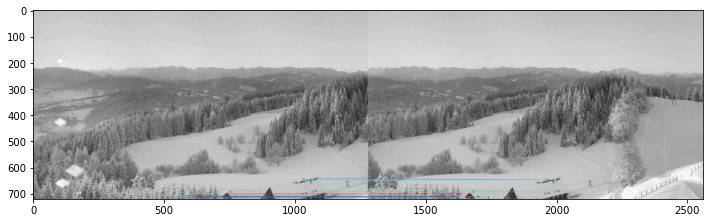

48 not enough good matching points, reset img0


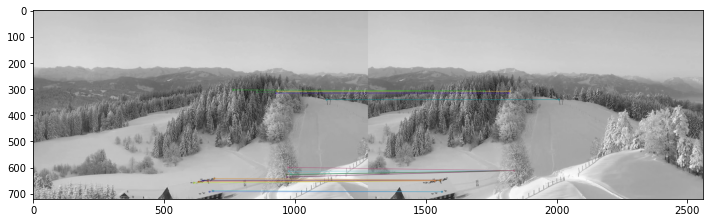

57 not enough good matching points, reset img0


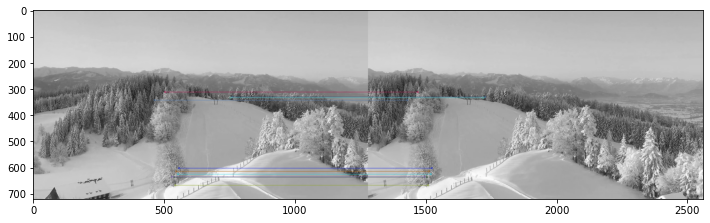

64 not enough good matching points, reset img0


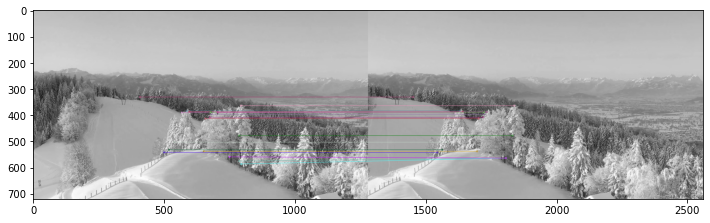

71 not enough good matching points, reset img0


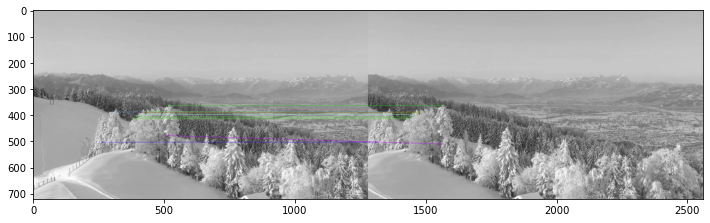

80 not enough good matching points, reset img0


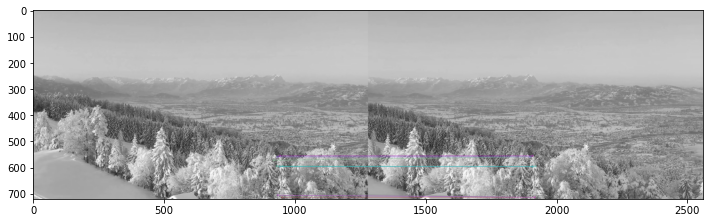

89 not enough good matching points, reset img0


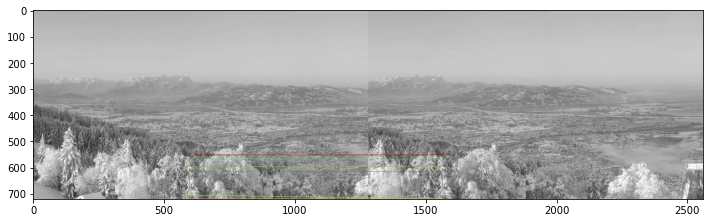

94 not enough good matching points, reset img0


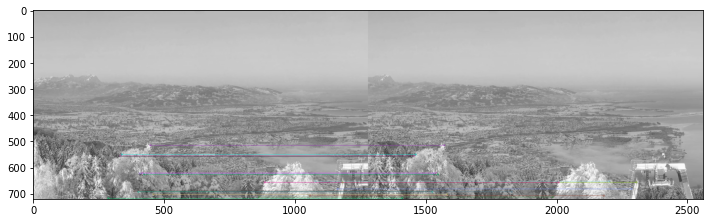

106 not enough good matching points, reset img0


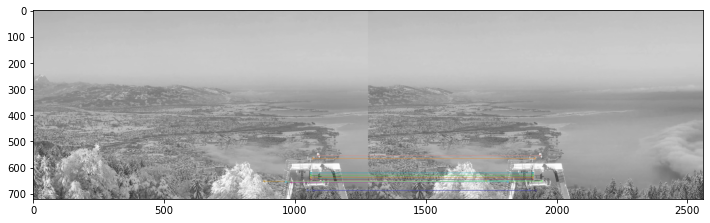

119 not enough good matching points, reset img0


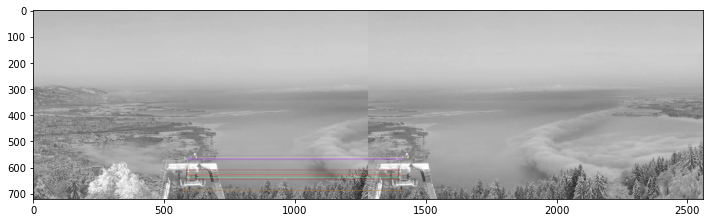

127 not enough good matching points, reset img0


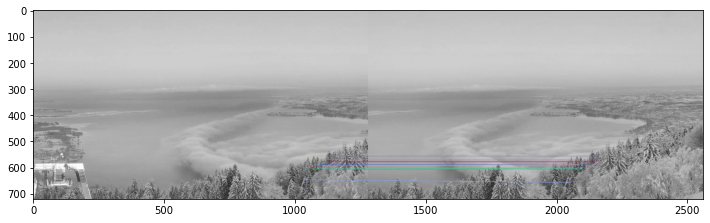

In [17]:
for i in range(1, len(imgs)):
    img1 = cv2.cvtColor(imgs[i],cv2.COLOR_BGR2GRAY)
    
    #gftt

    #oflk
    p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)

    # good points
    good1 = p1[st==1]
    good0 = p0[st==1]
    
    # convert to kp
    kp1, des1, kp2, des2 = sift_descriptor(good0, good1, img0, img1)
    matches, matchesMask = match_descriptor(kp1, des1, kp2, des2)
    
    good_matches = match_ratio(matches, img0, img1, kp1, kp2, isdraw=False)
    
    # get back good1 after finding good matches
    good0_ = np.float32([ kp1[m[0].trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    good1_ = np.float32([ kp2[m[0].queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    
    
    
    if len(good1_)<10:
        print(i, 'not enough good matching points, reset img0')
        keyframe_indices.append(i)
        keyframes.append(keyframe)
        keypoints.append(keymatches)
        img3 = cv2.drawMatchesKnn(img0,keymatches[0],keyframe,keymatches[1],keymatches[2],None,flags=2)
        plt.figure(figsize=(12,12))
        plt.imshow(img3)
        plt.show()
        
        img0 = img1
        p0 = cv2.goodFeaturesToTrack(img0, mask = None, **feature_params)
    else:
        # save key frames
        keyframe = img1
        keymatches = (kp1, kp2, good_matches, good0_, good1_)
        # update p0
        p0 = good0_
        
    
#     _i = img0.copy()
#     for p in good0_.squeeze():
#         cv2.circle(_i, tuple(p), 15, (255,0,0), 2)
    
#     _k = img1.copy()
#     for p in good1_.squeeze():
#         cv2.circle(_k, tuple(p), 15, (255,0,0), 2)
        
#     fig, ax = plt.subplots(1, 2, figsize=(15,15))
#     ax[0].imshow(_i, cmap='gray')
#     ax[1].imshow(_k, cmap='gray')
#     plt.show()
    

In [18]:
keyframe_indices

[0, 6, 15, 27, 37, 48, 57, 64, 71, 80, 89, 94, 106, 119, 127]

In [29]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    rect = np.int32([t[1], h2+t[1],t[0], w2+t[0]])
    return result, rect

In [49]:
stitcher = cv2.Stitcher_create(mode=cv2.STITCHER_PANORAMA)
stitcher.setPanoConfidenceThresh(0.3)
stitcher.setRegistrationResol(0.6)
stitcher.setSeamEstimationResol(0.1)
stitcher.setCompositingResol(0.3)

In [50]:
keyframe_count = len(keyframes)
keyframe_count

8

In [19]:
# save keyframes for external processing
from shutil import copy2
import os

for k in keyframe_indices:
    copy2(image_names[k], os.path.basename(image_names[k]))

0 1 0
2 3 0
4 5 0
6 7 0
0 1 0
2 3 0
0 1 0


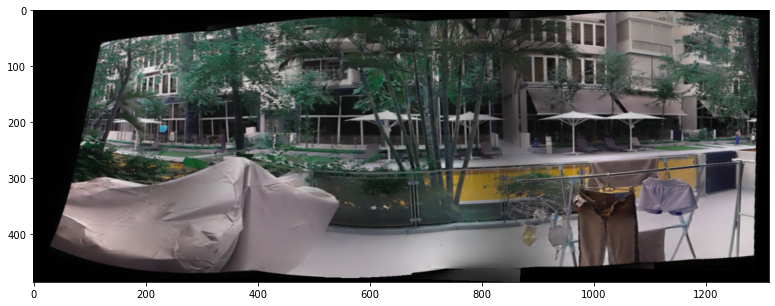

In [63]:
def stitch_recursive(stitcher, stitches, isgray=True):
    img_count = len(stitches)
    if img_count == 1:  # last
        # import pdb; pdb.set_trace()
        return stitches[0]
    else: # recursively stitch
        groups = zip(range(0, img_count, 2), range(1, img_count+1, 2))
        _stitches = []
        for i, j in groups:
            if j == img_count:
                j -= 1
            imgs = stitches[i:j+1]
            if isgray:
                imgs_c = [np.dstack([img0, img0, img0]) for img0 in imgs]
            else:
                imgs_c = imgs
            if len(imgs_c) == 1:
                _stitches.append(imgs_c[0])
                print(i, j, 4)
            else:
                status, _stitched  = stitcher.stitch(imgs_c)
                print(i, j, status)
                _stitches.append(_stitched)
        # if(len(_stitches)==2):
            # import pdb;pdb.set_trace()
        return stitch_recursive(stitcher, _stitches, False)

keyframes_c = [imgs[i] for i in keyframe_indices]
stitched = stitch_recursive(stitcher, keyframes_c, False)
        
plt.figure(figsize=(16,5))
plt.imshow(stitched)
plt.show()

In [64]:
ret, stitched1 = stitcher.stitch(keyframes_c)

In [67]:
cv2.imwrite("pano_162930_7.jpg", stitched)

True

In [76]:
import cv2
warper = cv2.PyRotationWarper("cylindrical", 10)

In [ ]:
warper.warp()